In [1]:
# Make sure that you have all these libaries available to run the code successfully
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data
# import matplotlib
# %matplotlib notebook

# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import datetime as dt
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
import sklearn
import scipy
import data_utils
from tqdm import tqdm



from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# plt.rcParams['figure.figsize'] = [20, 10]


In [2]:
## LOADING DATA
df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
print('Loaded data from the Kaggle repository')

Loaded data from the Kaggle repository


In [3]:
## EXPLORING DATA
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()



,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


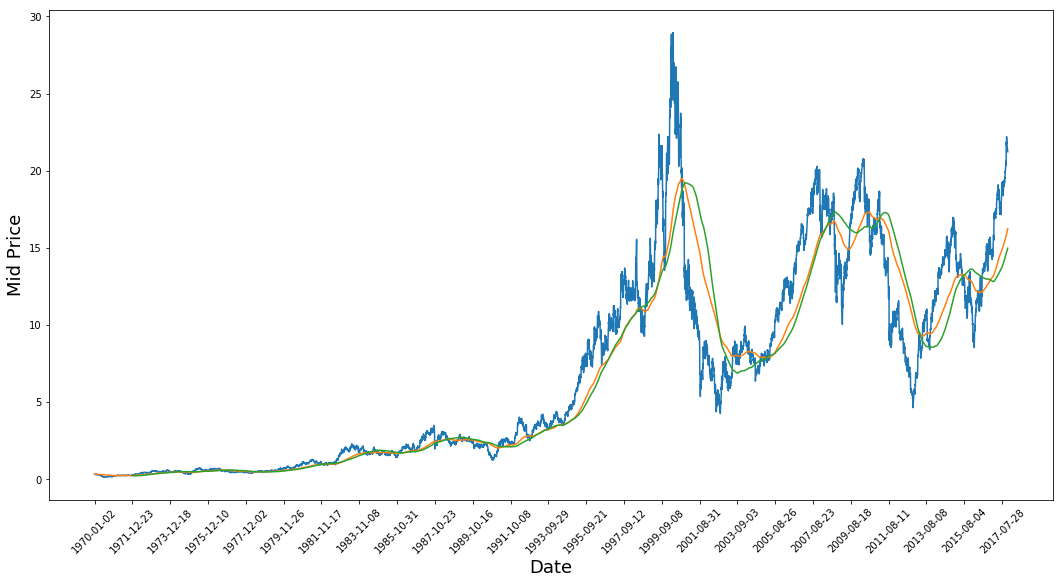

In [4]:
## VISUALIZE DATA
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.plot(range(df.shape[0]),((df['Low']+df['High'])/2.0).ewm(span=500, adjust=False).mean())
plt.plot(range(df.shape[0]),((df['Low']+df['High'])/2.0).rolling(window=500).mean())


plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

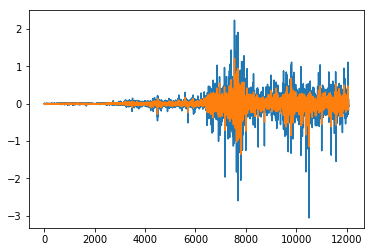

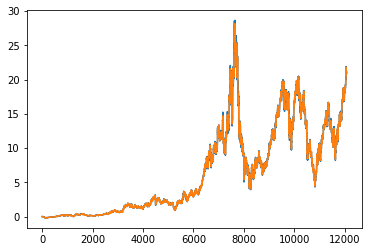

In [5]:
## Preprocess data
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].values
low_prices = df.loc[:,'Low'].values
mid_prices = (high_prices+low_prices)/2.0


diff = np.diff(mid_prices, n=1)
diff_smoothed = data_utils.get_smoothed_gauss_1d(diff, sigma=1)


plt.plot(diff)
plt.plot(diff_smoothed)
plt.show()

plt.plot(diff.cumsum())
plt.plot(diff_smoothed.cumsum())
plt.show()


# train_data, test_data = data_utils.get_split_data(mid_prices, 0.8)




## Here is the explanation on num_steps from Tensorflow’s tutorial:

By design, the output of a recurrent neural network (RNN) depends on arbitrarily distant inputs. Unfortunately, this makes backpropagation computation difficult. In order to make the learning process tractable, it is common practice to create an “unrolled” version of the network, which contains a fixed number (num_steps) of LSTM inputs and outputs. The model is then trained on this finite approximation of the RNN. This can be implemented by feeding inputs of length num_steps at a time and performing a backward pass after each such input block.

The sequence of prices are first split into non-overlapped small windows. Each contains input_size numbers and each is considered as one independent input element. Then any num_steps consecutive input elements are grouped into one training input, forming an “un-rolled” version of RNN for training on Tensorfow. The corresponding label is the input element right after them.

For instance, if input_size=3 and num_steps=2, my first few training examples would look like:

Input1=[[p0,p1,p2],[p3,p4,p5]],Label1=[p6,p7,p8]

Input2=[[p3,p4,p5],[p6,p7,p8]],Label2=[p9,p10,p11]

Input3=[[p6,p7,p8],[p9,p10,p11]],Label3=[p12,p13,p14]


In [21]:
## Defining graohs

size_per_step = 10
steps_per_sample = 10
steps_per_prediction = 5
batch_size = 32


lstm_size=128
lstm_layer_sizes =  [256, 128]
init_learning_rate = 0.001
learning_rate_decay = 0.99
init_epoch = 5
max_epoch = 50


# batch_seq1, batch_seq2 = data_utils.get_random_shifted_seq_batch_v2(diff_smoothed, batch_size,
#                                     inputs_per_step, steps_per_sample, steps_per_prediction)

tf.reset_default_graph()
lstm_graph = tf.Graph()


with lstm_graph.as_default():

        # Dimension = (
    #     number of data examples, 
    #     number of input in one computation step, 
    #     number of numbers in one input
    # )
    # We don't know the number of examples beforehand, so it is None.
    X = tf.placeholder(tf.float32, [None, steps_per_sample,      size_per_step])
    Y = tf.placeholder(tf.float32, [None, steps_per_prediction,  size_per_step])
    
    learning_rate = tf.placeholder(tf.float32, None)
    
    lstm_cells = [tf.contrib.rnn.LSTMCell(layer_size, state_is_tuple=True) for layer_size in lstm_layer_sizes]
    multi_lstm_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells, state_is_tuple=True)
    outputs, states = tf.nn.dynamic_rnn(multi_lstm_cell, X, dtype=tf.float32)
    
    # Before transpose, val.get_shape() = (batch_size, num_steps, lstm_size)
    # After transpose, val.get_shape() = (num_steps, batch_size, lstm_size)
    outputs = tf.transpose(outputs, [1, 0, 2])
    # last.get_shape() = (batch_size, lstm_size)
#     last = tf.gather(outputs, int(outputs.get_shape()[0]) - 1, name="last_lstm_output")
    last = outputs[-1]
    
    print(outputs)
    print(last)
    
    # between hidden and output layers
    y_pred = tf.layers.dense(last, size_per_step * steps_per_prediction)
    
    print(y_pred.shape)
    print(Y.shape)
    
    
    loss = tf.reduce_mean(tf.square(y_pred - tf.reshape(Y, [-1, size_per_step * steps_per_prediction])))
    optimizer = tf.train.RMSPropOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    


Tensor("transpose:0", shape=(10, ?, 128), dtype=float32)
Tensor("strided_slice:0", shape=(?, 128), dtype=float32)
(?, 50)
(?, 5, 10)


In [22]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>









  0%|          | 0/50 [00:00<?, ?it/s]

(1, 100)
(1, 50)
(1, 50)


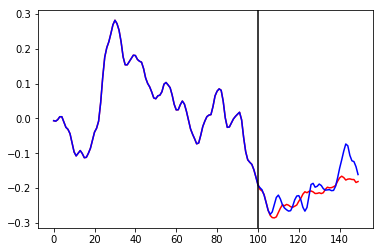









  2%|▏         | 1/50 [00:07<05:55,  7.27s/it]

(1, 100)
(1, 50)
(1, 50)


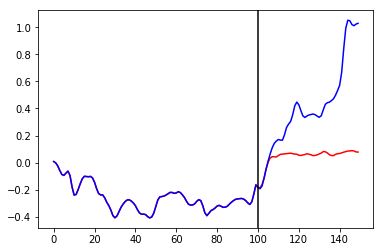









  4%|▍         | 2/50 [00:14<05:43,  7.17s/it]

(1, 100)
(1, 50)
(1, 50)


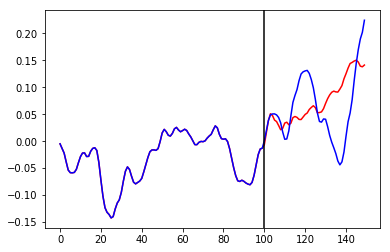









  6%|▌         | 3/50 [00:21<05:39,  7.22s/it]

(1, 100)
(1, 50)
(1, 50)


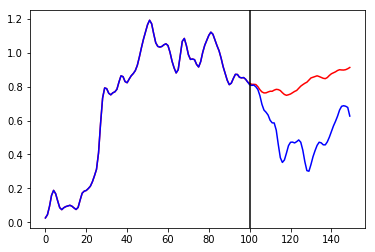









  8%|▊         | 4/50 [00:28<05:31,  7.21s/it]

(1, 100)
(1, 50)
(1, 50)


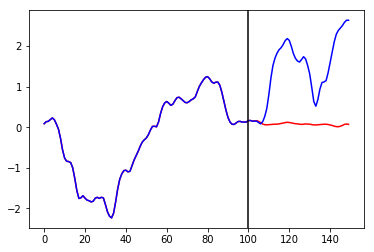









 10%|█         | 5/50 [00:36<05:24,  7.22s/it]

(1, 100)
(1, 50)
(1, 50)


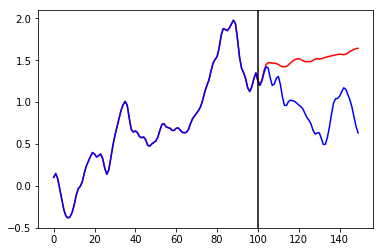









 12%|█▏        | 6/50 [00:43<05:18,  7.23s/it]

(1, 100)
(1, 50)
(1, 50)


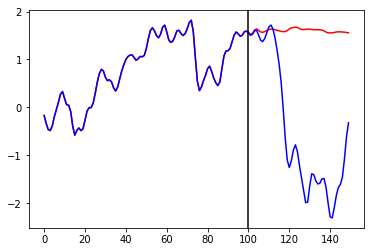









 14%|█▍        | 7/50 [00:50<05:10,  7.22s/it]

(1, 100)
(1, 50)
(1, 50)


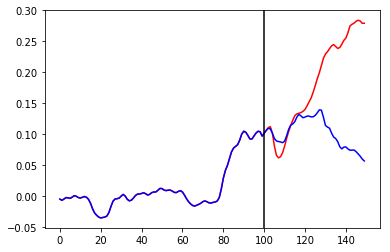









 16%|█▌        | 8/50 [00:57<05:03,  7.22s/it]

(1, 100)
(1, 50)
(1, 50)


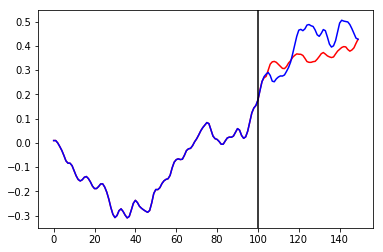









 18%|█▊        | 9/50 [01:04<04:55,  7.22s/it]

(1, 100)
(1, 50)
(1, 50)


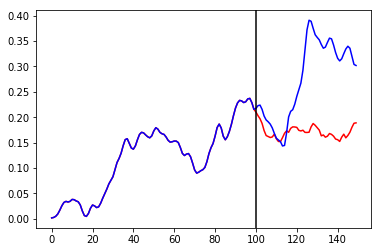









 20%|██        | 10/50 [01:12<04:48,  7.20s/it]

(1, 100)
(1, 50)
(1, 50)


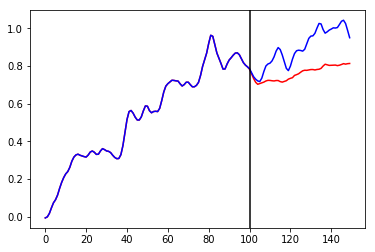









 22%|██▏       | 11/50 [01:19<04:40,  7.19s/it]

(1, 100)
(1, 50)
(1, 50)


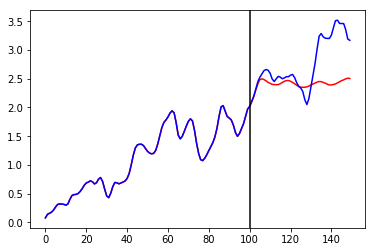









 24%|██▍       | 12/50 [01:26<04:32,  7.18s/it]

(1, 100)
(1, 50)
(1, 50)


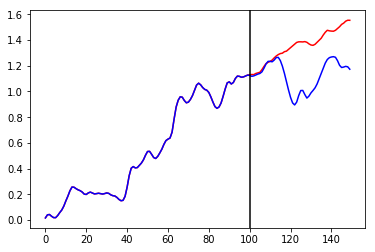









 26%|██▌       | 13/50 [01:33<04:26,  7.20s/it]

(1, 100)
(1, 50)
(1, 50)


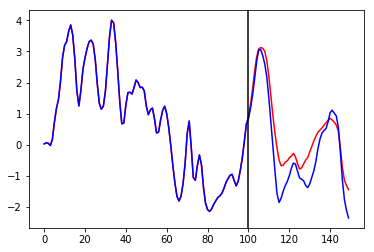









 28%|██▊       | 14/50 [01:40<04:18,  7.19s/it]

(1, 100)
(1, 50)
(1, 50)


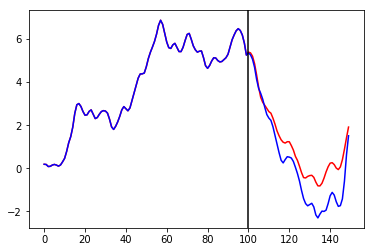









 30%|███       | 15/50 [01:47<04:11,  7.19s/it]

(1, 100)
(1, 50)
(1, 50)


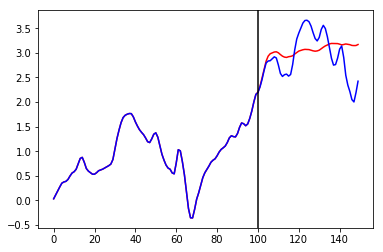









 32%|███▏      | 16/50 [01:54<04:04,  7.18s/it]

(1, 100)
(1, 50)
(1, 50)


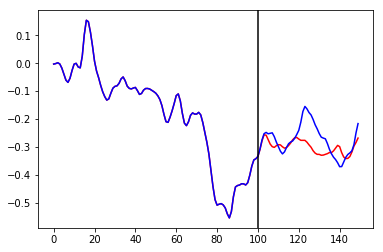









 34%|███▍      | 17/50 [02:01<03:56,  7.17s/it]

(1, 100)
(1, 50)
(1, 50)


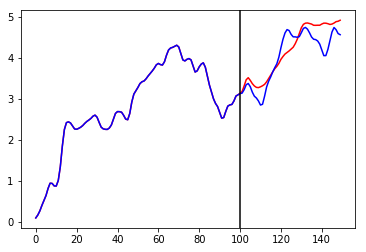









 36%|███▌      | 18/50 [02:09<03:50,  7.19s/it]

(1, 100)
(1, 50)
(1, 50)


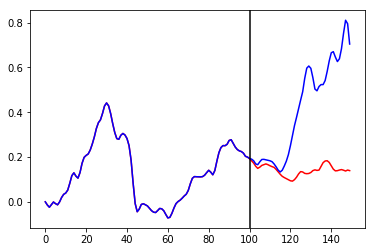









 38%|███▊      | 19/50 [02:16<03:42,  7.18s/it]

(1, 100)
(1, 50)
(1, 50)


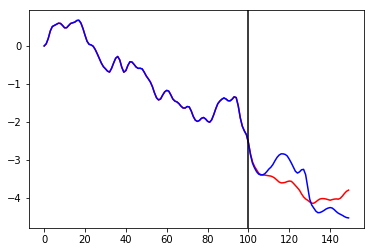









 40%|████      | 20/50 [02:23<03:35,  7.20s/it]

(1, 100)
(1, 50)
(1, 50)


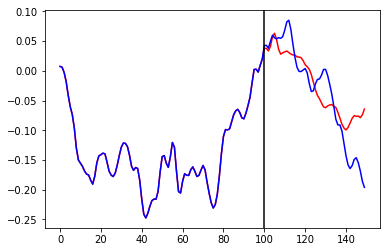









 42%|████▏     | 21/50 [02:31<03:28,  7.20s/it]

(1, 100)
(1, 50)
(1, 50)


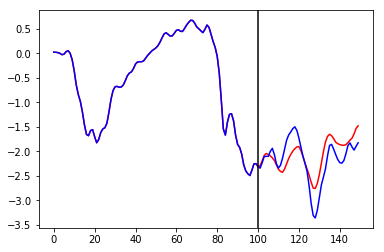









 44%|████▍     | 22/50 [02:38<03:21,  7.21s/it]

(1, 100)
(1, 50)
(1, 50)


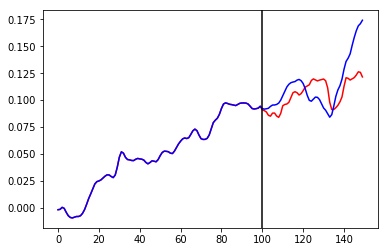









 46%|████▌     | 23/50 [02:45<03:14,  7.20s/it]

(1, 100)
(1, 50)
(1, 50)


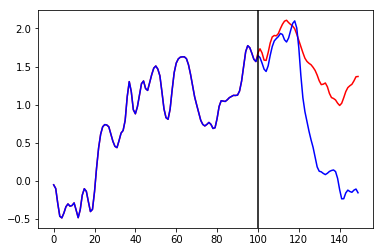









 48%|████▊     | 24/50 [02:52<03:07,  7.20s/it]

(1, 100)
(1, 50)
(1, 50)


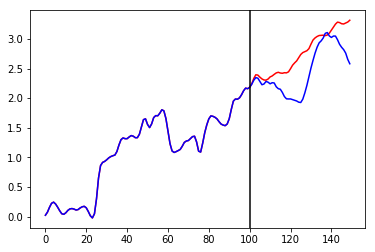









 50%|█████     | 25/50 [03:00<03:00,  7.21s/it]

(1, 100)
(1, 50)
(1, 50)


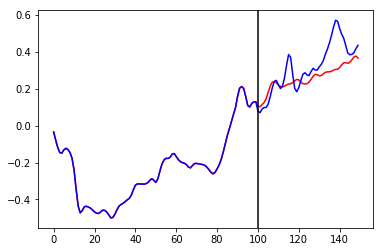









 52%|█████▏    | 26/50 [03:07<02:53,  7.21s/it]

(1, 100)
(1, 50)
(1, 50)


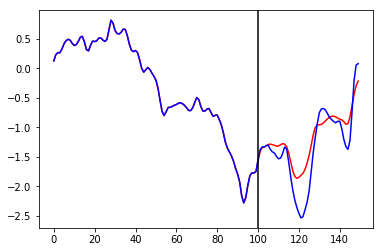









 54%|█████▍    | 27/50 [03:14<02:45,  7.21s/it]

(1, 100)
(1, 50)
(1, 50)


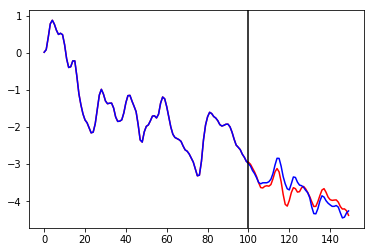









 56%|█████▌    | 28/50 [03:21<02:38,  7.20s/it]

(1, 100)
(1, 50)
(1, 50)


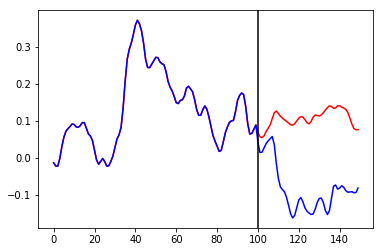









 58%|█████▊    | 29/50 [03:28<02:31,  7.20s/it]

(1, 100)
(1, 50)
(1, 50)


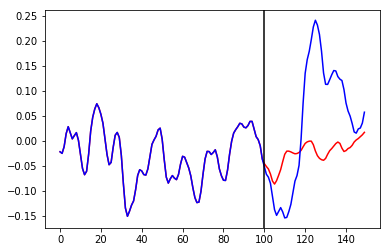









 60%|██████    | 30/50 [03:35<02:23,  7.19s/it]

(1, 100)
(1, 50)
(1, 50)


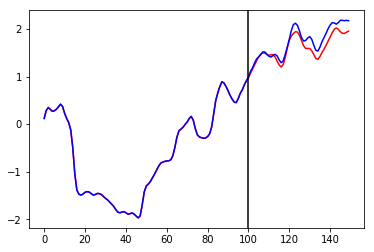









 62%|██████▏   | 31/50 [03:42<02:16,  7.19s/it]

(1, 100)
(1, 50)
(1, 50)


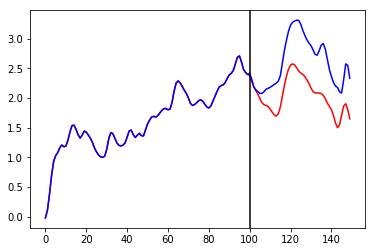









 64%|██████▍   | 32/50 [03:50<02:09,  7.19s/it]

(1, 100)
(1, 50)
(1, 50)


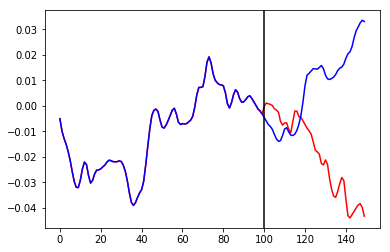









 66%|██████▌   | 33/50 [03:57<02:02,  7.19s/it]

(1, 100)
(1, 50)
(1, 50)


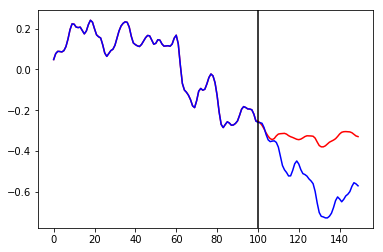









 68%|██████▊   | 34/50 [04:04<01:55,  7.20s/it]

(1, 100)
(1, 50)
(1, 50)


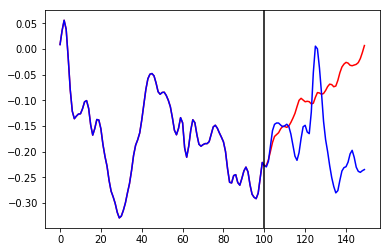









 70%|███████   | 35/50 [04:11<01:47,  7.20s/it]

(1, 100)
(1, 50)
(1, 50)


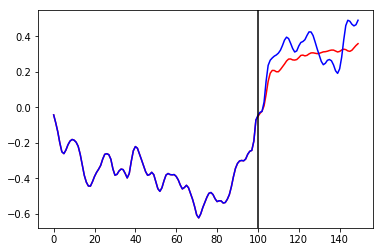









 72%|███████▏  | 36/50 [04:18<01:40,  7.19s/it]

(1, 100)
(1, 50)
(1, 50)


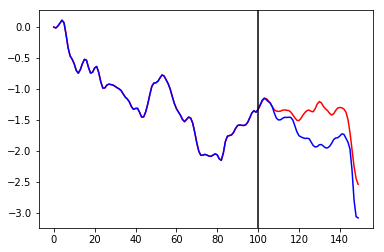









 74%|███████▍  | 37/50 [04:26<01:33,  7.19s/it]

(1, 100)
(1, 50)
(1, 50)


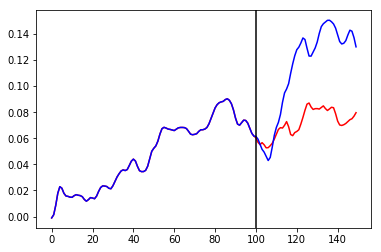









 76%|███████▌  | 38/50 [04:33<01:26,  7.19s/it]

(1, 100)
(1, 50)
(1, 50)


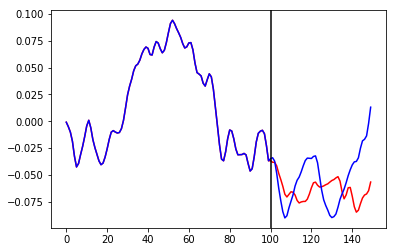









 78%|███████▊  | 39/50 [04:40<01:19,  7.18s/it]

(1, 100)
(1, 50)
(1, 50)


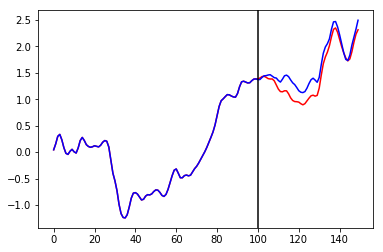









 80%|████████  | 40/50 [04:47<01:11,  7.18s/it]

(1, 100)
(1, 50)
(1, 50)


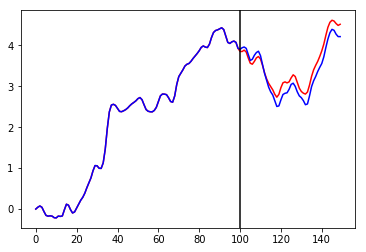









 82%|████████▏ | 41/50 [04:54<01:04,  7.18s/it]

(1, 100)
(1, 50)
(1, 50)


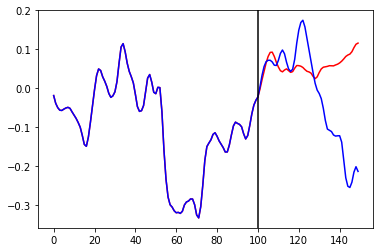









 84%|████████▍ | 42/50 [05:01<00:57,  7.17s/it]

(1, 100)
(1, 50)
(1, 50)


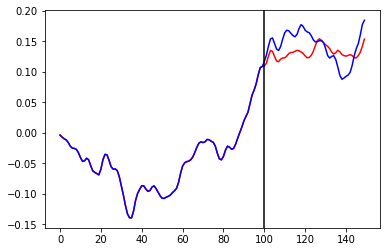









 86%|████████▌ | 43/50 [05:08<00:50,  7.17s/it]

(1, 100)
(1, 50)
(1, 50)


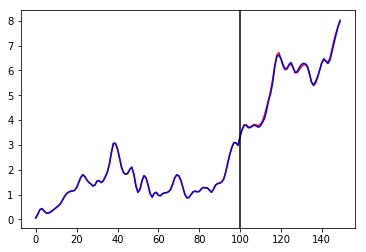









 88%|████████▊ | 44/50 [05:16<00:43,  7.18s/it]

(1, 100)
(1, 50)
(1, 50)


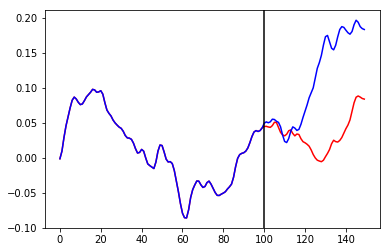









 90%|█████████ | 45/50 [05:23<00:35,  7.19s/it]

(1, 100)
(1, 50)
(1, 50)


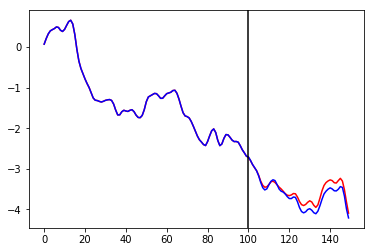









 92%|█████████▏| 46/50 [05:30<00:28,  7.19s/it]

(1, 100)
(1, 50)
(1, 50)


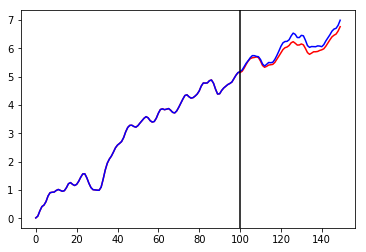









 94%|█████████▍| 47/50 [05:37<00:21,  7.19s/it]

(1, 100)
(1, 50)
(1, 50)


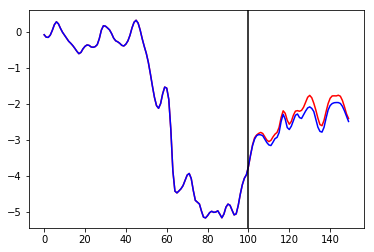









 96%|█████████▌| 48/50 [05:44<00:14,  7.19s/it]

(1, 100)
(1, 50)
(1, 50)


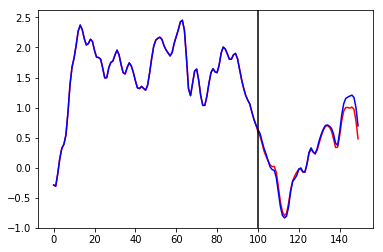









 98%|█████████▊| 49/50 [05:52<00:07,  7.19s/it]

(1, 100)
(1, 50)
(1, 50)


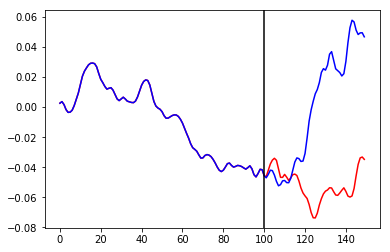









100%|██████████| 50/50 [05:59<00:00,  7.18s/it]









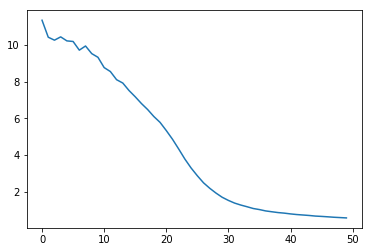

In [23]:

with tf.Session(graph=lstm_graph) as sess:
    sess.run(tf.global_variables_initializer())
        
    learning_rates_to_use = [
    init_learning_rate * (learning_rate_decay ** max(float(i + 1 - init_epoch), 0.0)) for i in range(max_epoch)]
    
    
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     plt.ion()
#     fig.show()
#     fig.canvas.draw()
    
    losses = []
    
    for epoch_step in tqdm(range(max_epoch)):
        current_lr = learning_rates_to_use[epoch_step]

        # Check https://github.com/lilianweng/stock-rnn/blob/master/data_wrapper.py
        # if you are curious to know what is StockDataSet and how generate_one_epoch() 
        # is implemented.
        epoch_loss = 0
        for i in range(1000):
            
            batch_X, batch_y = data_utils.get_random_shifted_seq_batch_v2(diff_smoothed, batch_size,
                                                 size_per_step, steps_per_sample, steps_per_prediction)
            train_data_feed = {
                X: batch_X, 
                Y: batch_y, 
                learning_rate: current_lr
            }
            train_loss, _ = sess.run([loss, train_op], train_data_feed)
            epoch_loss += train_loss
        losses.append(epoch_loss)
        
        
        
        size= 1
        batch_X, batch_y = data_utils.get_random_shifted_seq_batch_v2(diff_smoothed, size,
                                                     size_per_step, steps_per_sample, steps_per_prediction)
        train_data_feed = {
                X: batch_X, 
            }
        pred = sess.run(y_pred, train_data_feed)

        batch_y = batch_y.reshape([size, size_per_step * steps_per_prediction])
        batch_X = batch_X.reshape([size, size_per_step * steps_per_sample])

    
        print(batch_X.shape)
        print(batch_y.shape)
        print(pred.shape)
        

        for x, y in zip(batch_y, pred):
            batch_X = batch_X.flatten()
            x = x.flatten()
            y.flatten()
            
            x = np.concatenate((batch_X, x))
            y = np.concatenate((batch_X, y))
            
            x = x.cumsum()
            y = y.cumsum()
            

            
    #         z = np.concatenate((x, y))
            plt.plot(y, color='r')
            plt.plot(x, color='b')
    #         plt.plot(z)

        xcoord = [steps_per_sample * size_per_step]
        plt.axvline(x=xcoord, color='k')
        
        plt.show()

        

        
        
        
plt.plot(losses)
plt.show()
#         ax.clear()
#         ax.plot(losses)
#         fig.canvas.draw()


